In [56]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import seaborn as sns
import os

In [ ]:
input_dir = "Results"

excel_mode = True

In [61]:
animals_df = []
animals_df_unsorted = []

animals_df = pd.concat(animals, names=['animal_id']) 


#animals_df['experiment'] = animals_df['experiment'].str.replace(r'^.*?_', '', regex=True) # Remove recording name from experiment name



# Add helper columns
animals_df['has_number'] = animals_df['experiment'].str.contains(r'\d+')

animals_df['experiment_number'] = animals_df['experiment'].apply(get_number)

animals_df_unsorted = animals_df

# Sort by animal_id, then by if it has a number, then experiment type, then experiment number
animals_df = animals_df.sort_values(['date', 'animal_id', 'has_number', 'experiment', 'experiment_number'])

# Drop helper columns
animals_df = animals_df.drop(columns=['has_number', 'experiment_number'])

animals_df = animals_df.reset_index(level='animal_id').reset_index(drop=True)  # Flatten the index

# Drop helper columns
animals_df_unsorted = animals_df_unsorted.drop(columns=['has_number', 'experiment_number'])

animals_df_unsorted = animals_df_unsorted.reset_index(level='animal_id').reset_index(drop=True)  # Flatten the index

In [62]:
print(animals_df)

     animal_id     date       experiment  reactionTime  peakTime  difference  \
0            1  April16      ASR_control          14.4      30.0        15.6   
1            1  April16        gap_depth          15.0      30.0        15.0   
2            1  April16    tone_in_noise          15.0      30.0        15.0   
3            1  April16  gap_duration_10          15.2      27.6        12.4   
4            1  April16  gap_duration_20          14.0      30.0        16.0   
..         ...      ...              ...           ...       ...         ...   
211         15    May20    offset_PPI_20          15.2      30.4        15.2   
212         15    May20     offset_PPI_4          20.8      30.0         9.2   
213         15    May20    offset_PPI_50          16.5      31.0        14.5   
214         15    May20     offset_PPI_6          17.2      30.8        13.6   
215         15    May20     offset_PPI_8          17.5      30.5        13.0   

     strength  
0       32.40  
1      

In [63]:
print(animals_df_unsorted[['animal_id', 'experiment']].head(10))

   animal_id       experiment
0          1   gap_duration_8
1          1    offset_PPI_50
2          1    tone_in_noise
3          1    offset_PPI_10
4          1  gap_duration_10
5          1  gap_duration_20
6          1     offset_PPI_6
7          1   gap_duration_4
8          1    offset_PPI_16
9          1    offset_PPI_18


In [64]:
def plot_reaction_times(df):
    """
    Plots boxplots comparing each animal's reaction times across experiments.
    Each animal's reaction time is represented by a dot.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['animal_id', 'experiment', 'reactionTime']
    """
    # Check if required columns exist
    required_cols = {'animal_id', 'experiment', 'reactionTime'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Create a list of unique experiments
    experiments = df['experiment'].unique()

    # Create a list of animal_ids for each experiment
    animal_ids = df['animal_id'].unique()

    # Prepare a color map based on animal_id
    color_map = plt.get_cmap("tab20", len(animal_ids))

    # Plot boxplots per experiment
    positions = np.arange(len(experiments))  # X positions for boxplots
    boxplot_data = [df[df['experiment'] == exp]['reactionTime'].values for exp in experiments]
    
    # Create the boxplot without notches
    plt.boxplot(boxplot_data, positions=positions, widths=0.6, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='blue', alpha=0.5), 
                whiskerprops=dict(color='blue', linewidth=2, alpha=0.5), 
                capprops=dict(color='blue', linewidth=2, alpha=0.5))

    # Overlay the dots for each animal
    for i, exp in enumerate(experiments):
        exp_data = df[df['experiment'] == exp]
        for j, animal in enumerate(animal_ids):
            # Get the reaction time for the specific animal in this experiment
            animal_data = exp_data[exp_data['animal_id'] == animal]
            # Plot each animal's reaction time as a dot
            plt.scatter([i] * len(animal_data), animal_data['reactionTime'], 
                        label=animal if i == 0 else "", 
                        color=color_map(j), zorder=5, s=70, edgecolors="black", alpha=0.8)

    # Customize the plot
    plt.xticks(positions, experiments)  # Set x-ticks to be the experiments
    plt.xticks(rotation=45)
    plt.title("Reaction Times Across Experiments and Dates")
    plt.xlabel("Experiment")
    plt.ylabel("Reaction Time (ms)")
    
    # Add legend for animal IDs
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates from legend
    plt.legend(by_label.values(), by_label.keys(), title="Animal ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [65]:
def plot_reaction_times_avg_dates(df):
    """
    Plots boxplots comparing each animal's averaged reaction times across experiments.
    Each animal's reaction time is represented by a dot.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['animal_id', 'experiment', 'reactionTime', 'date']
    """
    # Check if required columns exist
    required_cols = {'animal_id', 'experiment', 'reactionTime', 'date'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Step 1: Average reaction times per animal per experiment (across dates)
    averaged_df = df.groupby(['experiment', 'animal_id'], as_index=False)['reactionTime'].mean()

    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Unique experiments and animal IDs
    experiments = averaged_df['experiment'].unique()
    animal_ids = averaged_df['animal_id'].unique()

    # Color map
    color_map = plt.get_cmap("tab20", len(animal_ids))

    # Prepare data for boxplots
    positions = np.arange(len(experiments))
    boxplot_data = [
        averaged_df[averaged_df['experiment'] == exp]['reactionTime'].values
        for exp in experiments
    ]

    # Create boxplot
    plt.boxplot(boxplot_data, positions=positions, widths=0.6, patch_artist=True, 
                boxprops=dict(facecolor='skyblue', color='blue', alpha=0.5), 
                whiskerprops=dict(color='blue', linewidth=2, alpha=0.5), 
                capprops=dict(color='blue', linewidth=2, alpha=0.5))

    # Overlay individual animal dots
    for i, exp in enumerate(experiments):
        exp_data = averaged_df[averaged_df['experiment'] == exp]
        for j, animal in enumerate(animal_ids):
            animal_data = exp_data[exp_data['animal_id'] == animal]
            plt.scatter([i] * len(animal_data), animal_data['reactionTime'], 
                        label=animal if i == 0 else "", 
                        color=color_map(j), zorder=5, s=70, edgecolors="black", alpha=0.8)

    # Customize plot
    plt.xticks(positions, experiments, rotation=45)
    plt.title("Average Reaction Times Across Experiments")
    plt.xlabel("Experiment")
    plt.ylabel("Reaction Time (ms)")

    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Animal ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


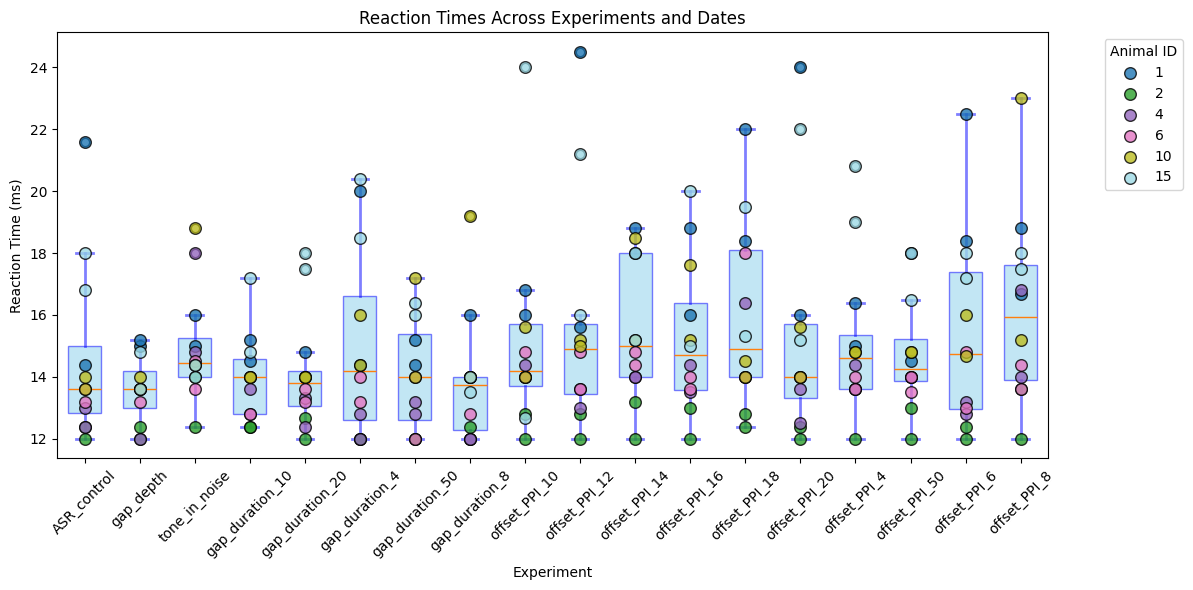

In [66]:
plot_reaction_times(animals_df)

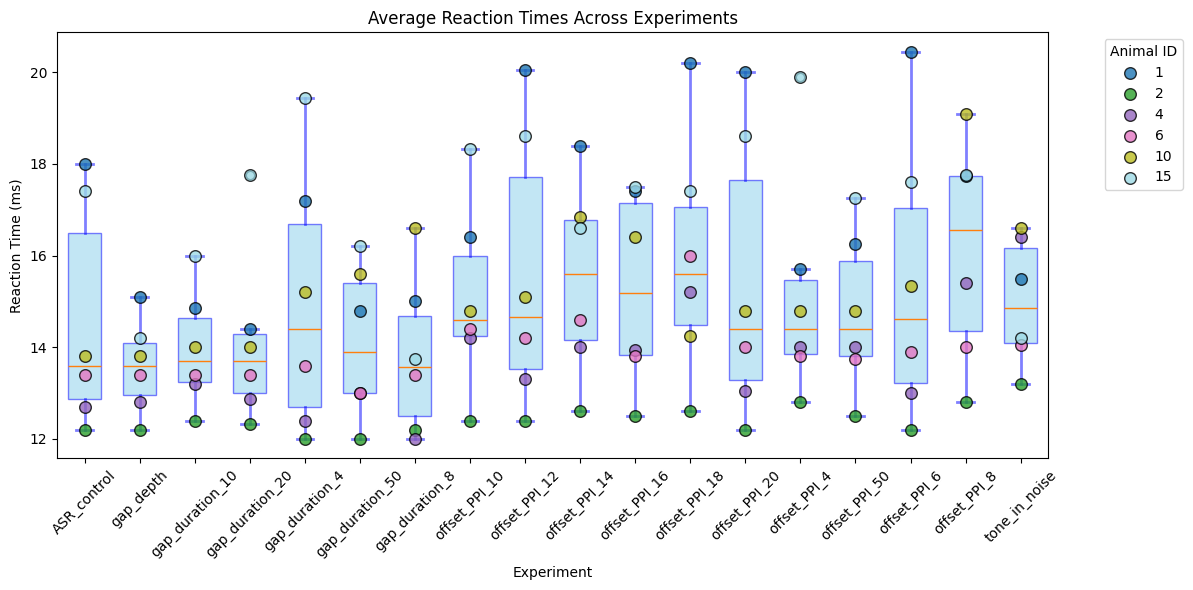

In [67]:
plot_reaction_times_avg_dates(animals_df)

In [68]:
def plot_animal(animal_id):
    animal_data = animals_df[animals_df['animal_id'] == animal_id]
    plt.figure(figsize=(10, 5))
    plt.bar(animal_data['experiment'], animal_data['reactionTime'])
    
    plt.title(f'Reaction Time by Experiment (Animal {animal_id})')
    plt.xlabel('Experiment')
    plt.ylabel('Reaction Time (ms)')

    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.grid(True)
    plt.show()

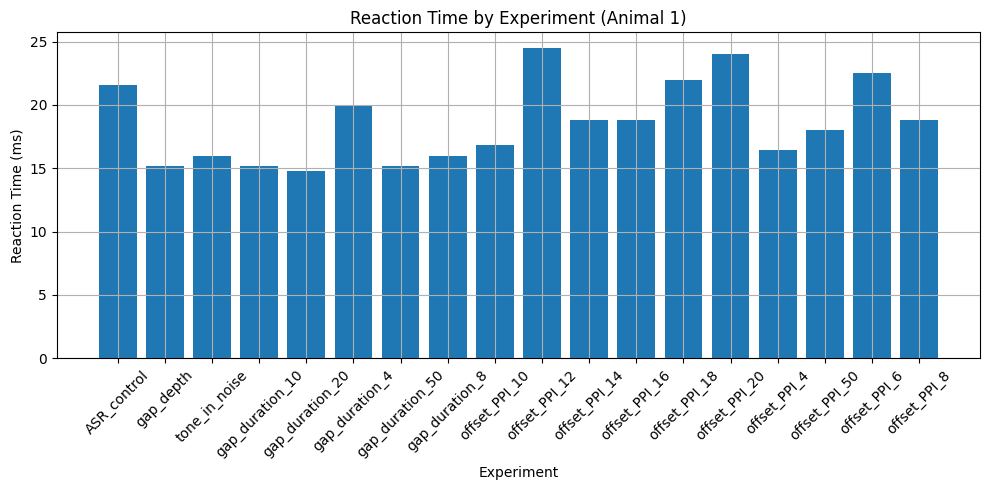

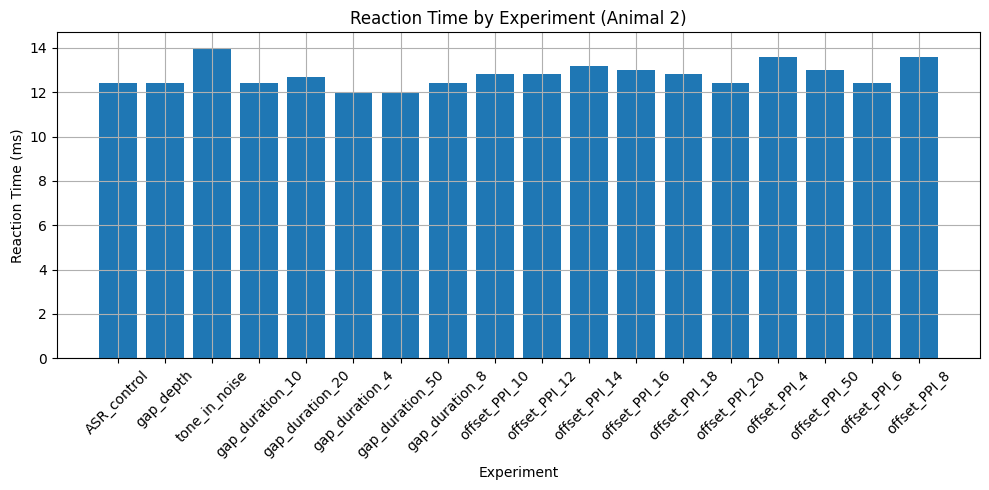

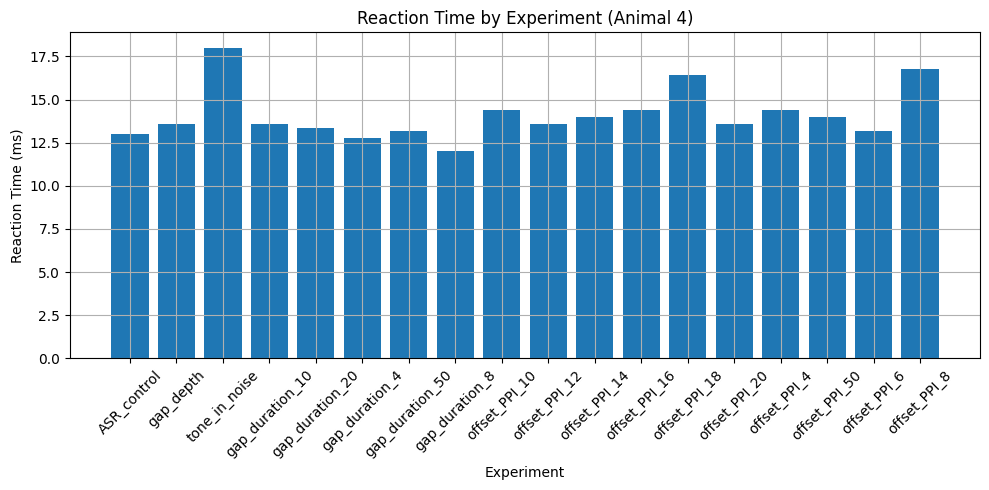

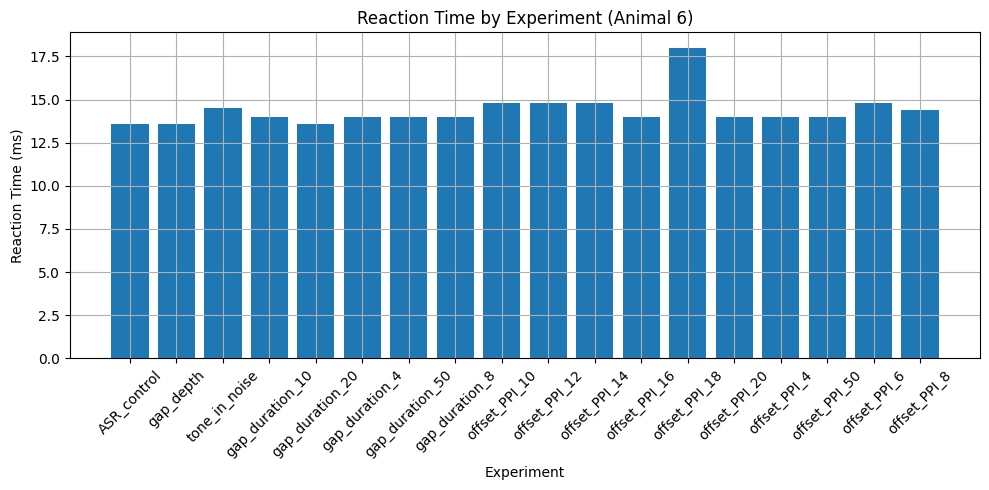

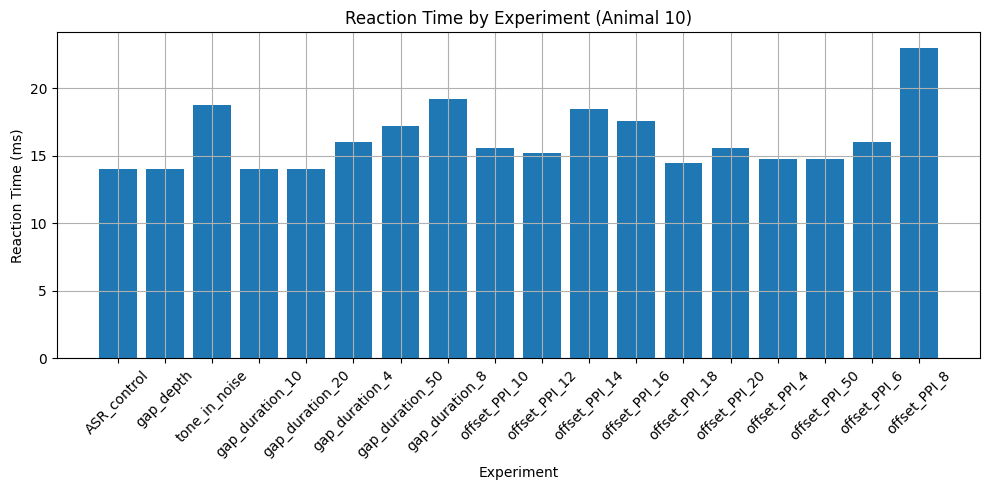

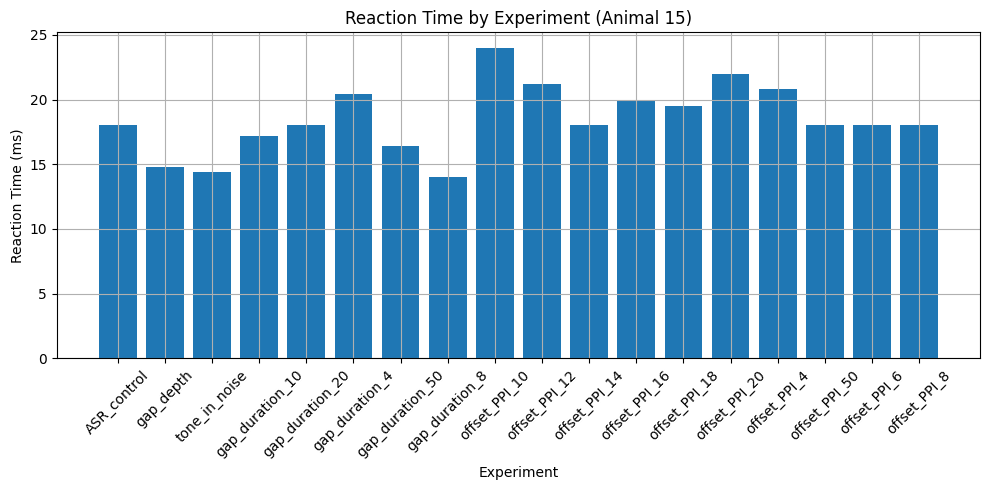

In [69]:
plot_animal(1)
plot_animal(2)
plot_animal(4)
plot_animal(6)
plot_animal(10)
plot_animal(15)